Lets first load few libraries. lphys is where we define our utility functions.

In [1]:
import lphys
import uproot
import probfit
import iminuit
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import awkward as ak

We will load two files: one with data, the other with simulation. You can change the datafile to use the electrons dataset instead. You can also change the simulation for the CMS simulation.

In [2]:
# input files
data_file = "doubleMu2011_ntuple.root"
simu_file = "delpheAnalysisZ.root"

In [3]:
datafile = uproot.open(data_file)
simufile = uproot.open(simu_file)
datatree = datafile['LPHY2131analysis/WeakBosonsAnalysis']
simutree = simufile['LPHY2131analysis/WeakBosonsAnalysis']

We take the selection that we obtained previously, and we use it to derive the Invariant Mass distribution.

In [4]:
# cuts
def selection(events, branches=None):
    # first filter on the number of objects
    filter = (events.nMuons==2) & (events.nElectrons==0) & (events.nJets<10)
    selected = events[filter]
    # then apply a cut on the muon Pt
    filter = (selected.MuonsPt[:,0]>30) & (selected.MuonsPt[:,1]>20) 
    selected = selected[filter]
    # cut on the isolation
    filter = (selected.MuonIsolation[:,0]<0.2) & (selected.MuonIsolation[:,1]<0.2) 
    selected = selected[filter]
    # MET cut
    filter = (selected.MET_pt<100)
    selected = selected[filter]
    # mass cut (mostly for display
    filter = (selected.invMass<200)
    selected = selected[filter]  
   
    if branches:
        return selected[branches]
    else:
        return selected

In [5]:
selected_data = lphys.analyzeTree(datatree,["invMass"],selection=selection)
selected_simu = lphys.analyzeTree(simutree,["invMass"],selection=selection)

We want to determine the number of Z bosons that we have in data. 
For that, we will fit the data with 2 components: the signal histogram, and a background contribution.
Therefore, we first define a background model:

In [6]:
# background model
def background(x,b):
    return np.exp(b*x)
    #return max(0,a+b*x)

From there, we have to build a signal + background model.
Here, we will do what is called a "template fit", so our model is the sum of two histograms. 
The free parameters are the parameters of the background model (by defaults, a and b), and the normalization of each histogram.

The normalization could also be fixed to the number of events in the data.

Here, we define a pdf, and we construct a binned likelihod from it. 
We could also do a chi2 fit using ```probfit.BinnedChi2()```

In [7]:
# This defines the binning for the fit and the display below.
xlim=(40,140)
nbins=100

# For the signal, we will build a pdf from the histogram of the MC simulation. One degree of freedom is added for the normalization.
s,bin_edges = np.histogram(ak.to_numpy(selected_simu["invMass"]), bins=nbins, range=xlim, density=True ) # normalized histogram the signal
signal_pdf = probfit.Extended(probfit.pdf.HistogramPdf(s, bin_edges, xname='x'), extname='Ns')
# For the background, we use the function above, that we normalize. One degree of freedom is added for the normalization.
background_pdf = probfit.Extended(probfit.functor.Normalized(background, (bin_edges[0],bin_edges[-1])), extname='Nb')
# The total PDF is defined as the sum signal+background.
pdf = probfit.AddPdf(signal_pdf,background_pdf)

# We then define the cost function: (binned) chi2 or (binned) likelihood. 
# See https://probfit.readthedocs.io/en/latest/api.html#cost-function for more options.
binned_likelihood = probfit.BinnedLH(pdf, ak.to_numpy(selected_data["invMass"]).astype('double'), extended=True, bins=nbins,bound=xlim)
print(f"The parameters of the fit function are: {iminuit.describe(binned_likelihood)}")

The parameters of the fit function are: ['Ns', 'b', 'Nb']


Let's now prepare the fit.
For each parameter we should provide initial (guess) values and/or a range of acceptable values.
This is done by constructing a "Minuit" object.
Initial values are directly set using the name of the variable, while the range is set using ]```limit_[varname]=(low,high)```.

We can then draw the initial pdf together with the data.

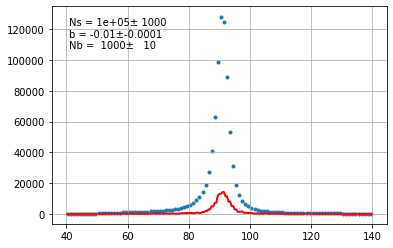

In [8]:
minuit = iminuit.Minuit(binned_likelihood, Ns=1E5, Nb=1E3, b = -0.01, limit_b=(-1E3,0))
binned_likelihood.draw(minuit);

Finally, we do the fit using the MIGRAD algorithm and we display the result.

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.011e+04                  │        Nfcn = 147 (147 total)        │
│ EDM = 1.08e-07 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Ns   │  836.7e3  │   0.9e3   │   -0.9e3   │   0.9e3    │         │         │       │
│ 1 │ b    │ -1.43e-3  │  0.27e-3  │  -0.27e-3  │  0.27e-3   │  -1000  │    0    │       │
│ 2 │ Nb   │  23.09e3  │  0.26e3   │  -0.26e3   │   0.26e3   │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

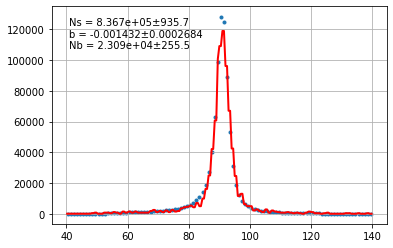

In [9]:
migradfit = minuit.migrad()
minuit.minos()
binned_likelihood.draw(minuit);
migradfit

Lets do a better plot:

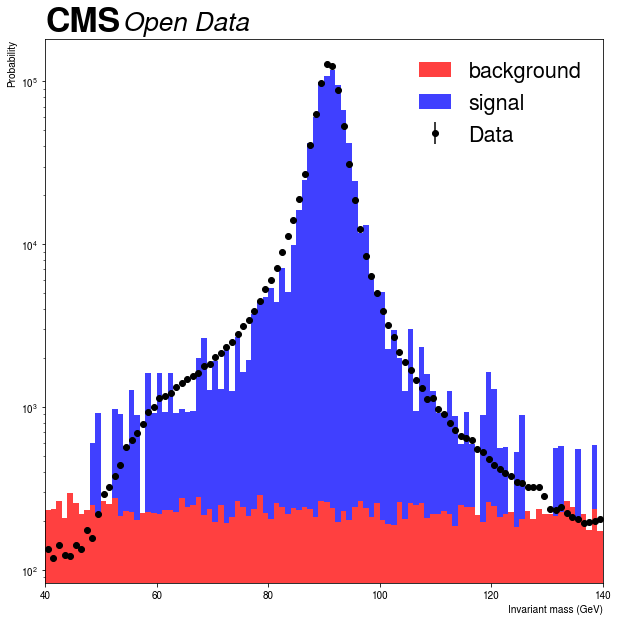

In [10]:
def useFit(migradfit):
    for param in migradfit[1]:
        globals()[param.name] = param.value
        globals()[f"{param.name}_unc"] = param.error
useFit(migradfit)

bkg    = lphys.sample(lphys.randomSample(lambda x: background_pdf(x,b,Nb),xlim,nbins,size=10000),
                      "background","red",integral=Nb)
signal = lphys.sample(selected_simu["invMass"],
                      "signal","blue",integral=Ns)

lphys.plot(selected_data["invMass"], [bkg,signal], [], 
           xlim, 'Invariant mass (GeV)', 'Probability', 
           nbins, islog=True, color='g', density=False)

Before concluding, we should look more closely at the fit results.
Want to extract quantities like the purity or the number of Z bosons, but we are also interested in the uncertainties and correlations, that we can access through the covariance matrix.

Summary data:

Purity: 95.81 +/- 0.11 %
Selection efficiency: 24.15 %
N_Z = 836741 +/- 936
N_bkg = 23086 +/- 256
N_data = 873308


/usr/local/lib64/python3.6/site-packages/matplotlib/ticker.py:2957: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


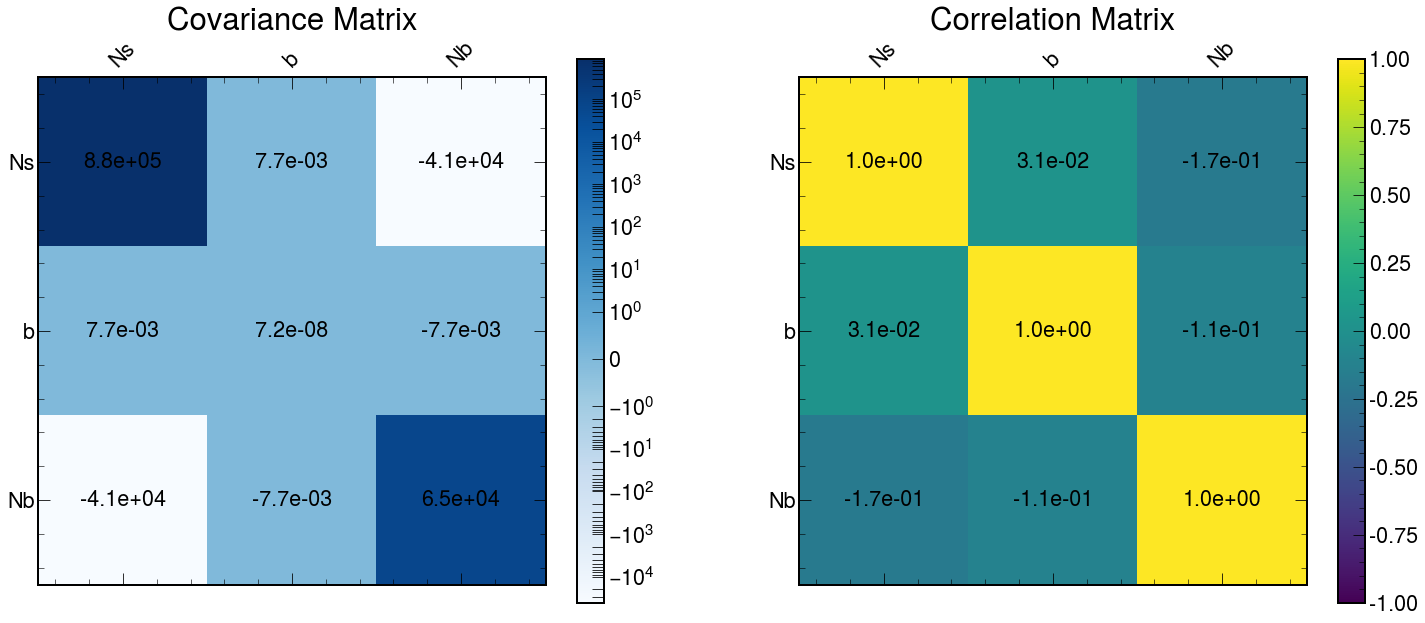

In [11]:
def useFit(migradfit):
    for param in migradfit[1]:
        globals()[param.name] = param.value
        globals()[f"{param.name}_unc"] = param.error
useFit(migradfit)
N = len(selected_data)

print("Summary data:\n")
print(f"Purity: { Ns/N*100:.2f} +/- {Ns_unc/N*100:.2f} %")
print(f"Selection efficiency: {len(selected_simu)/simutree.num_entries*100:.2f} %")
print(f"N_Z = {Ns:.0f} +/- {Ns_unc:.0f}")
print(f"N_bkg = {Nb:.0f} +/- {Nb_unc:.0f}")
print(f"N_data = {N}")

cov = minuit.np_covariance()
corr = lphys.correlation_from_covariance(cov)
fig, axs = plt.subplots(1, 2,figsize=(25, 10), sharey=False)
lphys.matrixPlot(fig,axs[1],corr,iminuit.describe(binned_likelihood),mrange=(-1,1))
lphys.matrixPlot(fig,axs[0],cov,iminuit.describe(binned_likelihood),"Blues",mrange="log")
axs[0].set_title('Covariance Matrix')
axs[1].set_title('Correlation Matrix')
plt.show()

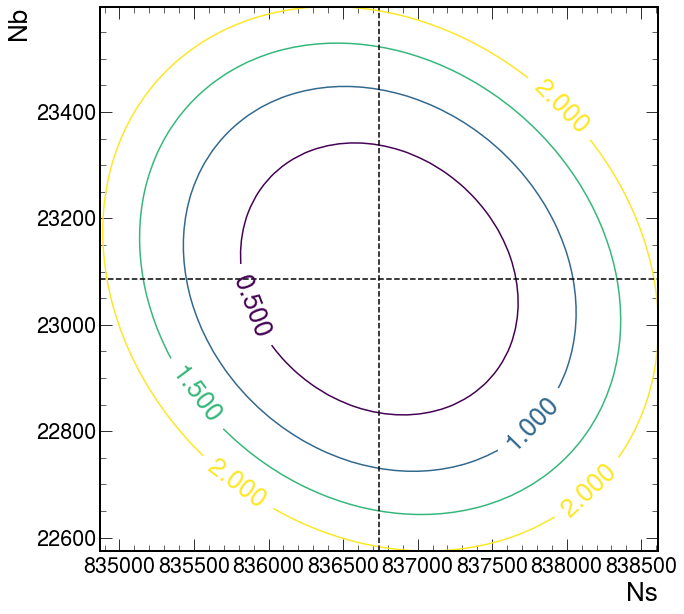

In [12]:
minuit.draw_contour("Ns", "Nb");